In [1]:
import shutil
import random
import os
os.chdir('mmpretrain')

In [2]:
# 1. 划分训练集和验证集
# 2. 按照 MMPreTrain CustomDataset 格式组织训练集和验证集
train_set = 'data/fruit30/train_set/'
val_set = 'data/fruit30/val_set/'
if not os.path.exists(train_set):
    os.makedirs(train_set)
if not os.path.exists(val_set):
    os.makedirs(val_set)

test_rate = 0.2
label_list = os.listdir('data/fruit30_train')
for label in label_list:
    if not os.path.exists(train_set + label):
        os.makedirs(train_set + label)
    if not os.path.exists(val_set + label):
        os.makedirs(val_set + label)
    img_list = os.listdir('data/fruit30_train/' + label)
    test_element = random.sample(img_list, int(test_rate * len(img_list)))
    for img in img_list:
        img_path = 'data/fruit30_train/' + label + '/' + img
        if img in test_element:
            new_img_path = val_set + label + '/' + label + img
        else:
            new_img_path = train_set + label + '/' + label + img
        shutil.copy(img_path, new_img_path) 

In [2]:
# 3. 使用 MMPreTrain 算法库，编写配置文件，正确加载预训练模型
from mmpretrain import get_model, list_models, inference_model
list_models(task='Image Classification', pattern='resnet50')

['resnet50_8xb16_cifar10',
 'resnet50_8xb16_cifar100',
 'resnet50_8xb256-rsb-a1-600e_in1k',
 'resnet50_8xb256-rsb-a2-300e_in1k',
 'resnet50_8xb256-rsb-a3-100e_in1k',
 'resnet50_8xb32-fp16_in1k',
 'resnet50_8xb32_in1k',
 'resnet50_8xb8_cub',
 'resnet50_barlowtwins-pre_8xb32-linear-coslr-100e_in1k',
 'resnet50_byol-pre_8xb512-linear-coslr-90e_in1k',
 'resnet50_densecl-pre_8xb32-linear-steplr-100e_in1k',
 'resnet50_mocov2-pre_8xb32-linear-steplr-100e_in1k',
 'resnet50_mocov3-100e-pre_8xb128-linear-coslr-90e_in1k',
 'resnet50_mocov3-300e-pre_8xb128-linear-coslr-90e_in1k',
 'resnet50_mocov3-800e-pre_8xb128-linear-coslr-90e_in1k',
 'resnet50_simclr-200e-pre_8xb512-linear-coslr-90e_in1k',
 'resnet50_simclr-800e-pre_8xb512-linear-coslr-90e_in1k',
 'resnet50_simsiam-100e-pre_8xb512-linear-coslr-90e_in1k',
 'resnet50_simsiam-200e-pre_8xb512-linear-coslr-90e_in1k',
 'resnet50_swav-pre_8xb32-linear-coslr-100e_in1k']

In [3]:
# 配置文件编写
# !mkdir projects/fruit30
# !touch resnet50_finetune.py
# 将config/resnet/resnet50_8xb32_in1k.py文件中, _base_的四个模型分别拷贝到 projects/fruit30/resnet50_finetune.py中
# 修改文件： 
# 1. model
# head.num_classes=30
# head.loss.num_classes=30
# init_cfg=dict(type='Pretrained', checkpoint='https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth')
# 2. dataset
# dataset_type = 'CustomDataset'
# data_preprocessor.num_class=30
# train_dataloader.data_root='../../data/fruit30/train_set'
# val_dataloader.data_root='../../data/fruit30/val_set'
# 以及删去用不到的prefix，auto_scale_lr等

In [4]:
# 3. 在水果数据集上进行微调训练
os.chdir('projects/fruit30')
# 训练
!mim train mmpretrain resnet50_finetune.py --work-dir=./exp 

In [5]:
# 测试
!mim test mmpretrain resnet50_finetune.py --checkpoint exp/best_accuracy/top1_epoch_65.pth --out result.pkl

In [6]:
# 分析
!mim run mmpretrain analyze_results resnet50_finetune.py result.pkl --out-dir analyze

In [7]:
# 绘制混淆矩阵
!mim run mmpretrain confusion_matrix resnet50_finetune.py result.pkl --show --include-values --show-path confusion_matrix
# 详见confusion_matrix.jpg

/bin/bash: /home/worker20/.conda/envs/MMPose/lib/python3.8/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
Use the script /files/OpenMMlabAI/MMPretain/mmpretrain/mmpretrain/.mim/tools/analysis_tools/confusion_matrix.py for command confusion_matrix.
The command to call is /home/worker20/.conda/envs/MMPose/bin/python /files/OpenMMlabAI/MMPretain/mmpretrain/mmpretrain/.mim/tools/analysis_tools/confusion_matrix.py resnet50_finetune.py result.pkl --show --include-values --show-path confusion_matrix. 
Figure(1000x1000)
The confusion matrix is saved at confusion_matrix.
The script finished successfully.


In [8]:
# 加载日志，绘制图像
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
import matplotlib 

# 载入训练日志
log_path = 'exp/20230609_152923/vis_data/scalars.json'
with open(log_path, "r") as f:
    json_list = f.readlines()
print("Length of json list is",len(json_list))
print(eval(json_list[4]))

df_train = pd.DataFrame()
df_test = pd.DataFrame()
for each in tqdm(json_list):
    if 'accuracy/top1' in each:
        df_test = df_test._append(eval(each), ignore_index=True)
    else:
        df_train = df_train._append(eval(each), ignore_index=True)
print(df_train.columns)

Length of json list is 1120
{'lr': 0.01, 'data_time': 0.00040051937103271487, 'loss': 3.5062124729156494, 'time': 0.11450228691101075, 'epoch': 1, 'memory': 4087, 'step': 50}


100%|█████████████████████████████████████| 1120/1120 [00:00<00:00, 3897.54it/s]

Index(['lr', 'data_time', 'loss', 'time', 'epoch', 'memory', 'step'], dtype='object')


In [9]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

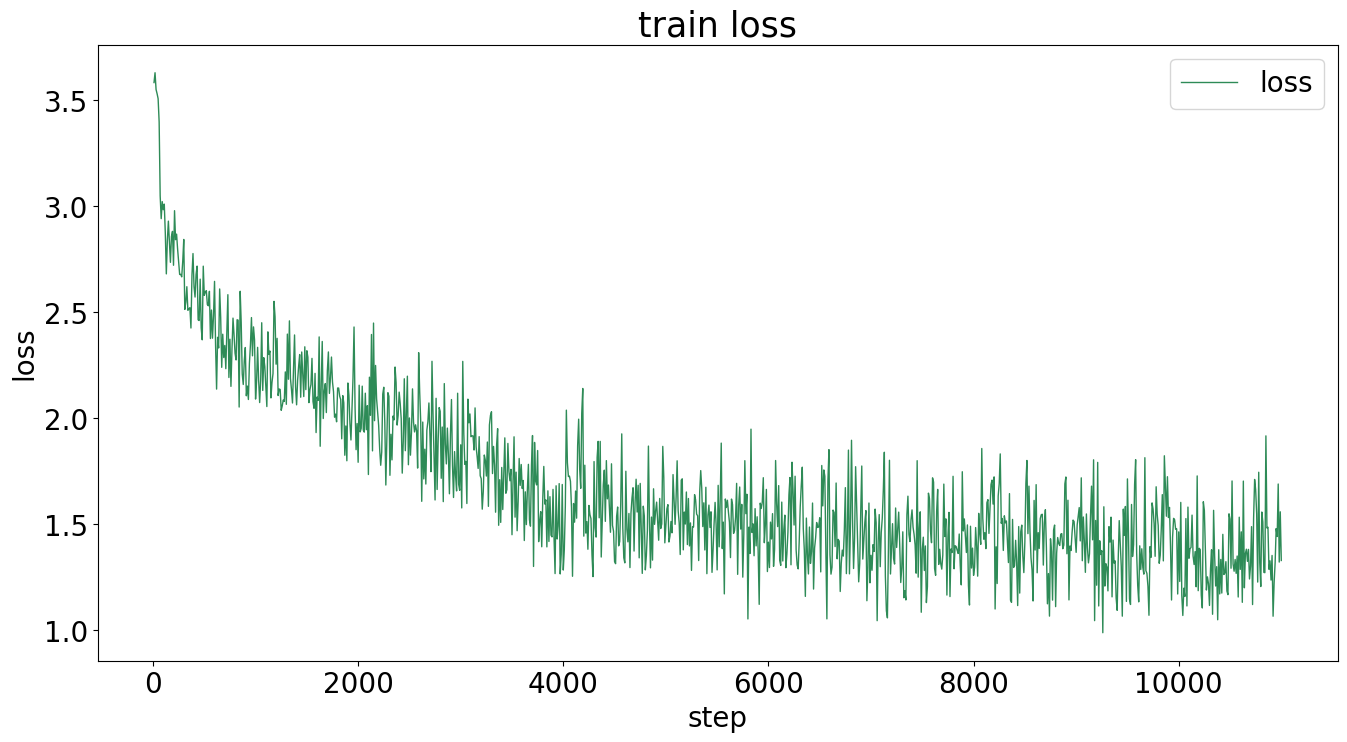

In [10]:
# 绘制训练集损失函数
metrics = ['loss']
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('train loss', fontsize=25)
plt.legend(fontsize=20)
plt.show()

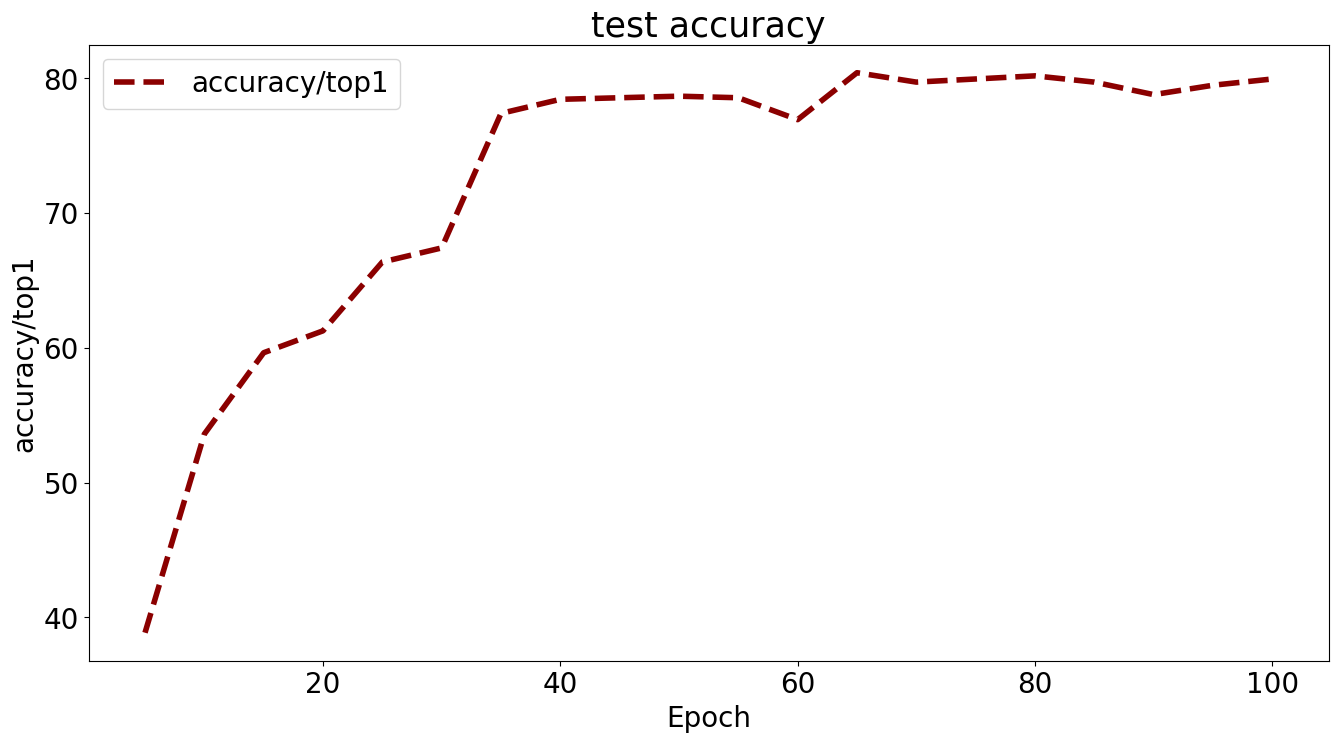

In [11]:
# 绘制测试集评估指标
metrics = ['accuracy/top1']
plt.figure(figsize=(16, 8))

x = df_test['step']
for y in metrics:
    plt.plot(x, df_test[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
# plt.ylim([0, 100])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel(y, fontsize=20)
plt.title('test accuracy', fontsize=25)
plt.legend(fontsize=20)
plt.show()

In [12]:
# 4. 使用 MMPreTrain 的 ImageClassificationInferencer 接口，对网络水果图像，或自己拍摄的水果图像，使用训练好的模型进行分类
from mmpretrain import ImageClassificationInferencer as inf
inferencer = inf('resnet50_finetune.py', pretrained = 'exp/best_accuracy/top1_epoch_65.pth')
inferencer('test_fruit/banana.jpeg', show = True)

06/09 16:42:15 - mmengine - INFO - Because batch augmentations are enabled, the data preprocessor automatically enables the `to_onehot` option to generate one-hot format labels.
Loads checkpoint by local backend from path: exp/best_accuracy/top1_epoch_65.pth


06/09 16:42:15 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


[{'pred_scores': array([1.64163783e-02, 1.94436545e-03, 4.59983170e-01, 9.14433680e-04,
         4.36555734e-03, 1.55766553e-03, 1.47736315e-02, 1.27610592e-02,
         1.15688890e-03, 3.16581968e-03, 5.49072726e-03, 2.75483285e-03,
         9.72324386e-02, 2.05188803e-02, 1.62811519e-03, 1.46704307e-03,
         4.78894264e-02, 9.97297117e-04, 1.21315278e-03, 9.48214717e-03,
         3.14435712e-03, 1.92191731e-03, 1.05272591e-01, 8.37535039e-03,
         9.62673500e-03, 8.54720362e-04, 1.41512305e-02, 3.52612697e-02,
         1.15396045e-01, 2.82776717e-04], dtype=float32),
  'pred_label': 2,
  'pred_score': 0.4599831700325012,
  'pred_class': 'banana'}]

In [13]:
inferencer('test_fruit/cherry.jpeg', show = True)

[{'pred_scores': array([1.0556033e-03, 5.6219241e-04, 3.3448110e-04, 8.5973076e-04,
         2.1131450e-04, 9.6136230e-01, 1.0678961e-03, 6.0588541e-04,
         1.4830164e-03, 8.2718342e-04, 7.7171270e-03, 1.1964763e-03,
         6.6689006e-04, 3.0570871e-03, 7.3690939e-04, 2.1439907e-03,
         3.4542647e-04, 1.7913943e-04, 1.7611675e-03, 5.2252235e-03,
         1.3080980e-03, 1.1734910e-03, 5.0517445e-04, 5.0465058e-04,
         4.8250397e-04, 2.2404520e-03, 2.5305533e-04, 3.4460094e-04,
         6.4272172e-04, 1.1462749e-03], dtype=float32),
  'pred_label': 5,
  'pred_score': 0.9613623023033142,
  'pred_class': 'cherry'}]

In [14]:
inferencer('test_fruit/watermelon.jpeg', show = True)

[{'pred_scores': array([0.00488255, 0.09566898, 0.00751719, 0.00304969, 0.02329665,
         0.01646796, 0.01711765, 0.03096444, 0.0135861 , 0.00117458,
         0.04372776, 0.0088633 , 0.00250285, 0.00771078, 0.02431177,
         0.00766164, 0.00355297, 0.00776362, 0.00217221, 0.00196506,
         0.01229567, 0.00413394, 0.00640684, 0.00104808, 0.00671735,
         0.00583268, 0.01313332, 0.00909221, 0.6109102 , 0.00647204],
        dtype=float32),
  'pred_label': 28,
  'pred_score': 0.610910177230835,
  'pred_class': 'watermelon'}]